<a href="https://colab.research.google.com/github/lecongnghi98/traffic-sign-classification/blob/main/cnn_backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 2. IMPORT PACKAGES

## 1. DOWNLOAD DATASET TỪ KAGGLE (Optional)

In [ ]:
import os

# Cách 1: Nhập trực tiếp (cho Google Colab)
kaggle_username = ""  # Thay bằng username của bạn
kaggle_key = ""  # Thay bằng API key của bạn

# Tạo thư mục .kaggle nếu chưa có
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

# Tạo file kaggle.json
kaggle_json = {
    "username": kaggle_username,
    "key": kaggle_key
}

import json
with open(os.path.expanduser("~/.kaggle/kaggle.json"), 'w') as f:
    json.dump(kaggle_json, f)

# Set permissions (chỉ owner được read/write)
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

print("Kaggle credentials đã được setup!")

✓ Kaggle credentials đã được setup!


In [ ]:
# Download dataset từ Kaggle
print("Đang download dataset từ Kaggle...")

!kaggle datasets download -d ahemateja19bec1025/traffic-sign-dataset-classification

print("\nDownload hoàn tất!")
print("\nĐang giải nén file...")

# Giải nén file
!unzip -q traffic-sign-dataset-classification.zip

print("Dataset đã được giải nén!")

# Kiểm tra cấu trúc thư mục
import os
print("\nCấu trúc thư mục:")
for root, dirs, files in os.walk(".", topdown=True):
    level = root.replace(".", "").count(os.sep)
    indent = " " * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    if level > 2:  # Chỉ hiển thị 3 levels
        break

Đang download dataset từ Kaggle...
Dataset URL: https://www.kaggle.com/datasets/ahemateja19bec1025/traffic-sign-dataset-classification
License(s): CC0-1.0
 63% 120M/190M [00:00<00:00, 1.24GB/s]
100% 190M/190M [00:00<00:00, 848MB/s] 

✓ Download hoàn tất!

Đang giải nén file...
✓ Dataset đã được giải nén!

📁 Cấu trúc thư mục:
./
  .config/
    configurations/
    logs/
      2025.12.09/


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

print(f"TensorFlow version: {tf.__version__}")
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.19.0
Num GPUs Available: 1


## 3. LOAD DATASET

In [ ]:
# Tìm đường dẫn dataset tự động
import os
import glob

# Tìm folder chứa dataset
possible_paths = [
    './traffic_signs/traffic_Data/DATA',
    './traffic_Data/DATA',
    './DATA',
    '/content/traffic_signs/traffic_Data/DATA',  # Google Colab
]

dataset_path = None

# Tìm trong thư mục hiện tại
for root, dirs, files in os.walk('.'):
    if 'DATA' in dirs and 'traffic' in root.lower():
        dataset_path = os.path.join(root, 'DATA')
        break

# Nếu không tìm thấy, thử các đường dẫn có thể
if dataset_path is None:
    for path in possible_paths:
        if os.path.exists(path):
            dataset_path = path
            break

if dataset_path is None:
    print("Không tìm thấy dataset!")
    print("Vui lòng chạy cell download ở trên hoặc nhập path thủ công:")
    dataset_path = input("Nhập đường dẫn tới folder DATA: ")
else:
    print(f"Tìm thấy dataset tại: {dataset_path}")

# Kiểm tra số lượng classes
if os.path.exists(dataset_path):
    num_folders = len([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
    print(f"  Số lượng classes: {num_folders}")
else:
    print(f"Path không tồn tại: {dataset_path}")

✓ Tìm thấy dataset tại: ./traffic_Data/DATA
  Số lượng classes: 58


In [ ]:
# Tạo training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='training',
    image_size=(224, 224),
    seed=123,
    batch_size=32
)

# Tạo validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='validation',
    image_size=(224, 224),
    seed=123,
    batch_size=32
)

# Lấy tên các classes
class_names = train_ds.class_names
num_classes = len(class_names)

print(f"\nSố lượng classes: {num_classes}")
print(f"Classes: {class_names[:5]}...")  # Hiển thị 5 class đầu

Found 4170 files belonging to 58 classes.
Using 3336 files for training.
Found 4170 files belonging to 58 classes.
Using 834 files for validation.

Số lượng classes: 58
Classes: ['0', '1', '10', '11', '12']...


## 4. VISUALIZE DATASET

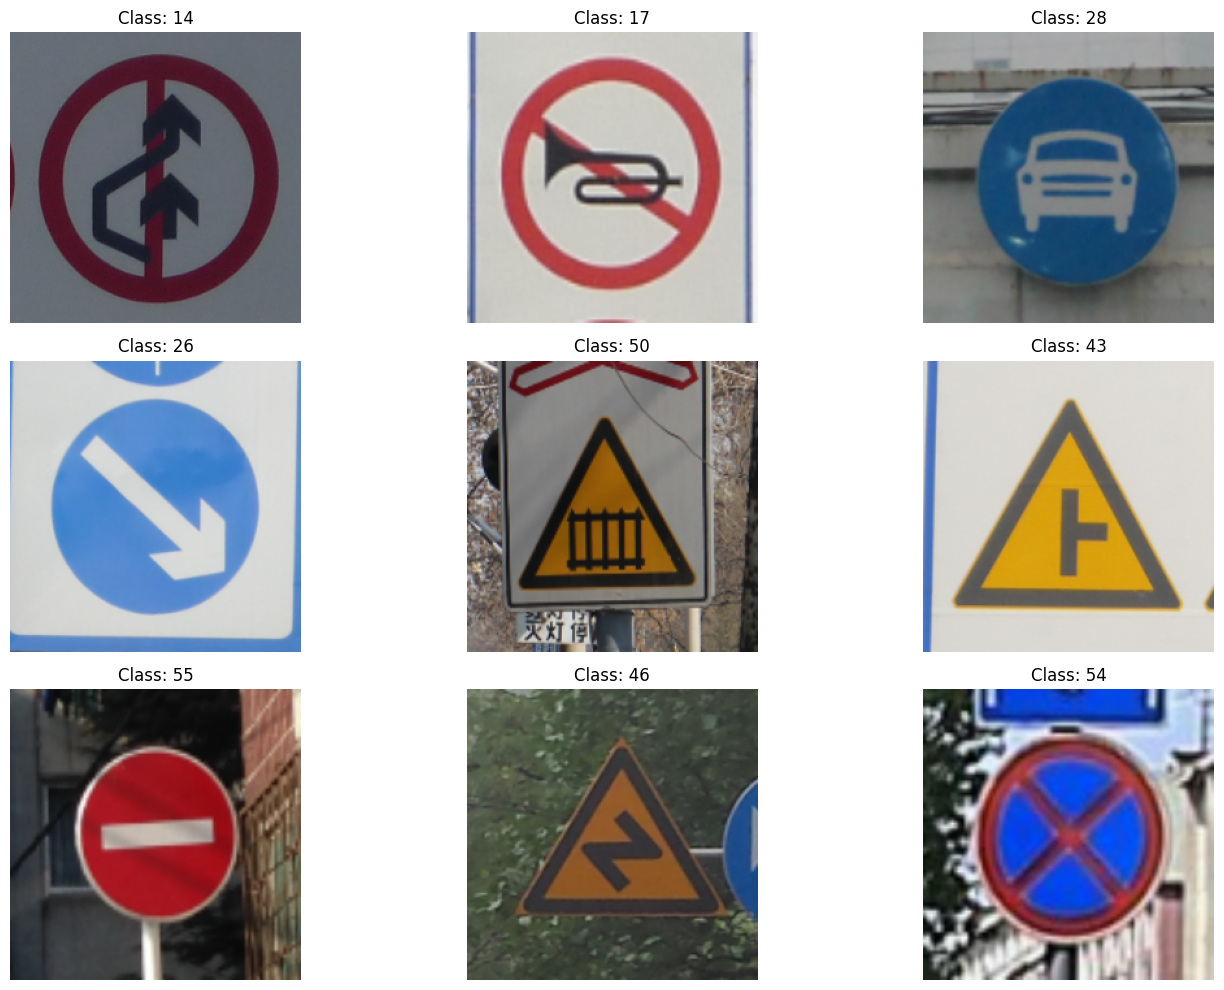

In [ ]:
# Hiển thị một số ảnh mẫu
plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Class: {class_names[labels[i]]}")
        plt.axis("off")
plt.tight_layout()
plt.show()

## 5. ĐỊNH NGHĨA MODELS

### 5.1 Hàm tạo Simple CNN

In [ ]:
def create_simple_cnn(num_classes, activation='relu', use_augmentation=False):
    """
    Tạo một CNN với kiến trúc deep (6 conv layers)

    Args:
        num_classes: Số lượng classes
        activation: Activation function cho conv layers
        use_augmentation: Có sử dụng data augmentation không

    Returns:
        model: Keras Sequential model
    """
    from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom

    # Tạo model layers
    layers = []

    # Data augmentation (chỉ thêm nếu use_augmentation=True)
    if use_augmentation:
        layers.extend([
            RandomFlip("horizontal_and_vertical", input_shape=(224, 224, 3)),
            RandomRotation(0.1),
            RandomZoom(0.1),
        ])

    # Rescaling: Normalize ảnh từ [0, 255] → [0, 1]
    layers.append(Rescaling(1./255, input_shape=(224, 224, 3), name='rescaling'))

    # Conv Blocks
    layers.extend([
        # Conv Block 1
        Conv2D(128, (3, 3), activation=activation, name='conv1'),
        MaxPooling2D((2, 2), name='pool1'),

        # Conv Block 2
        Conv2D(64, (3, 3), activation=activation, name='conv2'),
        MaxPooling2D((2, 2), name='pool2'),

        # Conv Block 3
        Conv2D(64, (3, 3), activation=activation, name='conv3'),
        MaxPooling2D((2, 2), name='pool3'),

        # Conv Block 4
        Conv2D(128, (3, 3), activation=activation, name='conv4'),
        MaxPooling2D((2, 2), name='pool4'),

        # Conv Block 5
        Conv2D(128, (3, 3), activation=activation, name='conv5'),
        MaxPooling2D((2, 2), name='pool5'),

        # Conv Block 6
        Conv2D(256, (3, 3), activation=activation, name='conv6'),
        MaxPooling2D((2, 2), name='pool6'),

        # Dense Block
        Flatten(name='flatten'),
        Dense(64, activation=activation, name='dense1'),
        Dropout(0.2, name='dropout1'),
        Dense(128, activation=activation, name='dense2'),
        Dense(num_classes, activation='softmax', name='output')
    ])

    model = Sequential(layers)
    return model

# Test tạo model (không dùng augmentation cho gradient analysis)
print("="*70)
print("TESTING MODEL ARCHITECTURE")
print("="*70)

test_model = create_simple_cnn(num_classes, use_augmentation=False)
test_model.summary()

print("\nModel architecture:")
print("   * 6 Conv2D layers (128→64→64→128→128→256)")
print("   * Rescaling layer (0-255 → 0-1)")
print("   * 2 Dense layers (64→128)")
print("   * Dropout 0.2")
print("\nLưu ý:")
print("   * use_augmentation=False cho gradient analysis")
print("   * use_augmentation=True cho final training")
print("="*70)

TESTING MODEL ARCHITECTURE


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 222, 222, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 111, 111, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 109, 109, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv2D)                  │ (None, 10, 10, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool5 (MaxPooling2D)            │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv6 (Conv2D)                  │ (None, 3, 3, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool6 (MaxPooling2D)            │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 58)             │         7,482 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 663,162 (2.53 MB)

 Trainable params: 663,162 (2.53 MB)

 Non-trainable params: 0 (0.00 B)


✅ Model architecture:
   • 6 Conv2D layers (128→64→64→128→128→256)
   • Rescaling layer (0-255 → 0-1)
   • 2 Dense layers (64→128)
   • Dropout 0.2

💡 Lưu ý:
   • use_augmentation=False cho gradient analysis
   • use_augmentation=True cho final training


### 5.2 Hàm Training One Step (để track gradient)

In [ ]:
def train_one_step(model, images, labels):
    """
    Training một step và return gradients

    Args:
        model: Keras model
        images: Batch của images
        labels: Batch của labels

    Returns:
        loss: Loss value
        acc: Accuracy
        gradients: List of gradients cho mỗi layer
    """
    with tf.GradientTape() as tape:
        # Forward pass
        predictions = model(images, training=True)

        # Tính loss
        loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)
        loss = tf.reduce_mean(loss)

    # Backward pass - tính gradients
    gradients = tape.gradient(loss, model.trainable_variables)

    # Tính accuracy
    pred_classes = tf.argmax(predictions, axis=1)
    labels_int64 = tf.cast(labels, tf.int64)
    acc = tf.reduce_mean(tf.cast(tf.equal(pred_classes, labels_int64), tf.float32))

    return loss, acc, gradients

print("Hàm train_one_step đã sẵn sàng!")

✓ Hàm train_one_step đã sẵn sàng!


## 6. MODEL 1: GRADIENT FLOW VISUALIZATION

Visualize gradient flow qua các layers

In [ ]:
# Tạo model để test gradient flow
model_1 = create_simple_cnn(num_classes)

# Lấy 1 batch data và tính gradients
# Sử dụng next(iter(train_ds)) để lấy một batch duy nhất
images, labels = next(iter(train_ds))

# Tính gradients
loss, acc, grads = train_one_step(model_1, images, labels)

# Phân tích gradients và xây dựng DataFrame
grad_data = []

# Khởi tạo iterators cho trainable_variables và grads
# Vì chúng được tạo ra theo thứ tự của các biến huấn luyện được của model
trainable_variables_iter = iter(model_1.trainable_variables)
grads_iter = iter(grads)

for layer in model_1.layers:
    # Chỉ xem xét các lớp có biến huấn luyện (kernel, bias)
    if layer.trainable_variables:
        for _ in layer.trainable_variables:
            var = next(trainable_variables_iter)
            grad = next(grads_iter)

            if grad is not None:
                # Lấy tên biến (kernel hoặc bias)
                variable_type = var.name.split('/')[-1].split(':')[0]
                # Tạo tên lớp hiển thị rõ ràng hơn (ví dụ: 'conv1_kernel', 'dense1_bias')
                display_layer_name = f"{layer.name}_{variable_type}"

                grad_data.append({
                    'Layer': display_layer_name,
                    'Mean Gradient': tf.reduce_mean(tf.abs(grad)).numpy(),
                    'Max Gradient': tf.reduce_max(tf.abs(grad)).numpy()
                })

# Tạo DataFrame
gradient_df = pd.DataFrame(grad_data)

print("\n" + "="*70)
print("GRADIENT FLOW ANALYSIS")
print("="*70)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {acc:.4f}")
print("\nGradient Statistics:")
print(gradient_df.to_string(index=False))
print("="*70)


GRADIENT FLOW ANALYSIS
Loss: 4.0609
Accuracy: 0.0625

Gradient Statistics:
 Layer  Mean Gradient  Max Gradient
kernel       0.000584      0.003953
  bias       0.001158      0.007146
kernel       0.000111      0.002350
  bias       0.002235      0.007887
kernel       0.000105      0.002256
  bias       0.002254      0.011846
kernel       0.000093      0.003225
  bias       0.002772      0.011820
kernel       0.000074      0.001878
  bias       0.003031      0.014645
kernel       0.000067      0.002032
  bias       0.003823      0.018355
kernel       0.000090      0.002777
  bias       0.007451      0.040998
kernel       0.000119      0.003445
  bias       0.010138      0.050722
kernel       0.000182      0.003669
  bias       0.023198      0.076720


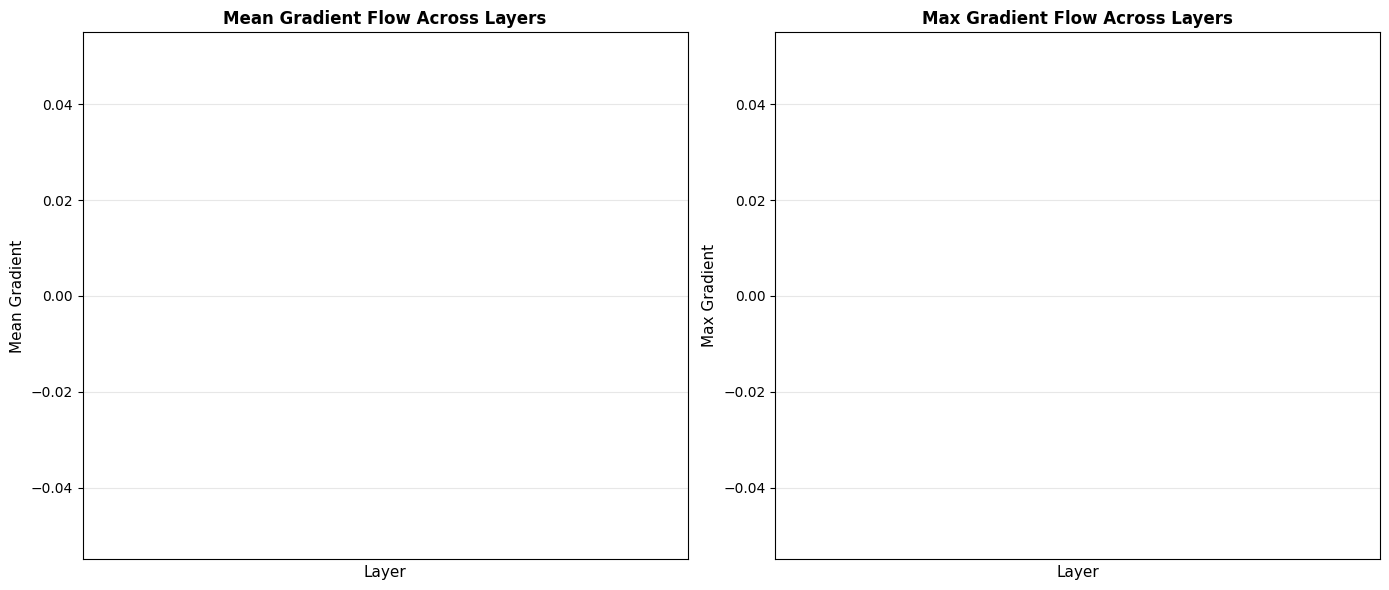

In [ ]:
# Visualize gradient flow
# Chỉ lấy layers chính (Conv, Dense)
# Cập nhật điều kiện lọc vì tên lớp trong gradient_df đã thay đổi (ví dụ: 'conv1_kernel')
main_layers_idx = [i for i, name in enumerate(gradient_df['Layer'])
                   if 'conv' in name or 'dense' in name]

# Nếu DataFrame trống, hiển thị cảnh báo và thoát
if gradient_df.empty or not main_layers_idx:
    print("Không có dữ liệu gradient để hiển thị cho các lớp Conv hoặc Dense.")
else:
    plt.figure(figsize=(14, 6))

    # Plot Mean Gradient
    plt.subplot(1, 2, 1)
    plt.bar(range(len(main_layers_idx)),
            [gradient_df['Mean Gradient'].iloc[i] for i in main_layers_idx],
            color='skyblue', edgecolor='navy')
    plt.xlabel('Layer', fontsize=11)
    plt.ylabel('Mean Gradient', fontsize=11)
    plt.title('Mean Gradient Flow Across Layers', fontsize=12, fontweight='bold')
    plt.xticks(range(len(main_layers_idx)),
               [gradient_df['Layer'].iloc[i] for i in main_layers_idx],
               rotation=45, ha='right')
    plt.grid(True, alpha=0.3)

    # Plot Max Gradient
    plt.subplot(1, 2, 2)
    plt.bar(range(len(main_layers_idx)),
            [gradient_df['Max Gradient'].iloc[i] for i in main_layers_idx],
            color='lightcoral', edgecolor='darkred')
    plt.xlabel('Layer', fontsize=11)
    plt.ylabel('Max Gradient', fontsize=11)
    plt.title('Max Gradient Flow Across Layers', fontsize=12, fontweight='bold')
    plt.xticks(range(len(main_layers_idx)),
               [gradient_df['Layer'].iloc[i] for i in main_layers_idx],
               rotation=45, ha='right')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

## 7. MODEL 2: SO SÁNH ACTIVATION FUNCTIONS

So sánh ReLU, Sigmoid, Tanh

In [ ]:
# Tạo 3 models với activation functions khác nhau
# Set seed để có kết quả nhất quán
import random
random.seed(42)
import numpy as np
np.random.seed(42)
tf.random.set_seed(42)

model_2_relu = create_simple_cnn(num_classes, activation='relu')
tf.random.set_seed(42)  # Reset seed cho model tiếp theo

model_2_sigmoid = create_simple_cnn(num_classes, activation='sigmoid')
tf.random.set_seed(42)  # Reset seed

model_2_tanh = create_simple_cnn(num_classes, activation='tanh')

print("Đã tạo 3 models: ReLU, Sigmoid, Tanh")
print("  (Tất cả bắt đầu với cùng random weights)")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✓ Đã tạo 3 models: ReLU, Sigmoid, Tanh
  (Tất cả bắt đầu với cùng random weights)


In [ ]:
# So sánh gradient của các activation functions
models_dict = {
    'ReLU': model_2_relu,
    'Sigmoid': model_2_sigmoid,
    'Tanh': model_2_tanh
}

results = {}

for name, model in models_dict.items():
    for images, labels in train_ds.take(1):
        loss, acc, grads = train_one_step(model, images, labels)

        # Tính mean gradient
        grad_means = [tf.reduce_mean(tf.abs(g)).numpy() for g in grads if g is not None]

        results[name] = {
            'loss': loss.numpy(),
            'accuracy': acc.numpy(),
            'mean_gradient': np.mean(grad_means),
            'max_gradient': np.max(grad_means)
        }
        break

# Hiển thị kết quả
print("\n" + "="*70)
print("SO SÁNH ACTIVATION FUNCTIONS")
print("="*70)
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"  Loss: {metrics['loss']:.4f}")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  Mean Gradient: {metrics['mean_gradient']:.6f}")
    print(f"  Max Gradient: {metrics['max_gradient']:.6f}")
print("="*70)


SO SÁNH ACTIVATION FUNCTIONS

ReLU:
  Loss: 4.0617
  Accuracy: 0.0625
  Mean Gradient: 0.003566
  Max Gradient: 0.024379

Sigmoid:
  Loss: 4.1650
  Accuracy: 0.0000
  Mean Gradient: 0.002490
  Max Gradient: 0.023061

Tanh:
  Loss: 4.0496
  Accuracy: 0.0000
  Mean Gradient: 0.009066
  Max Gradient: 0.023752


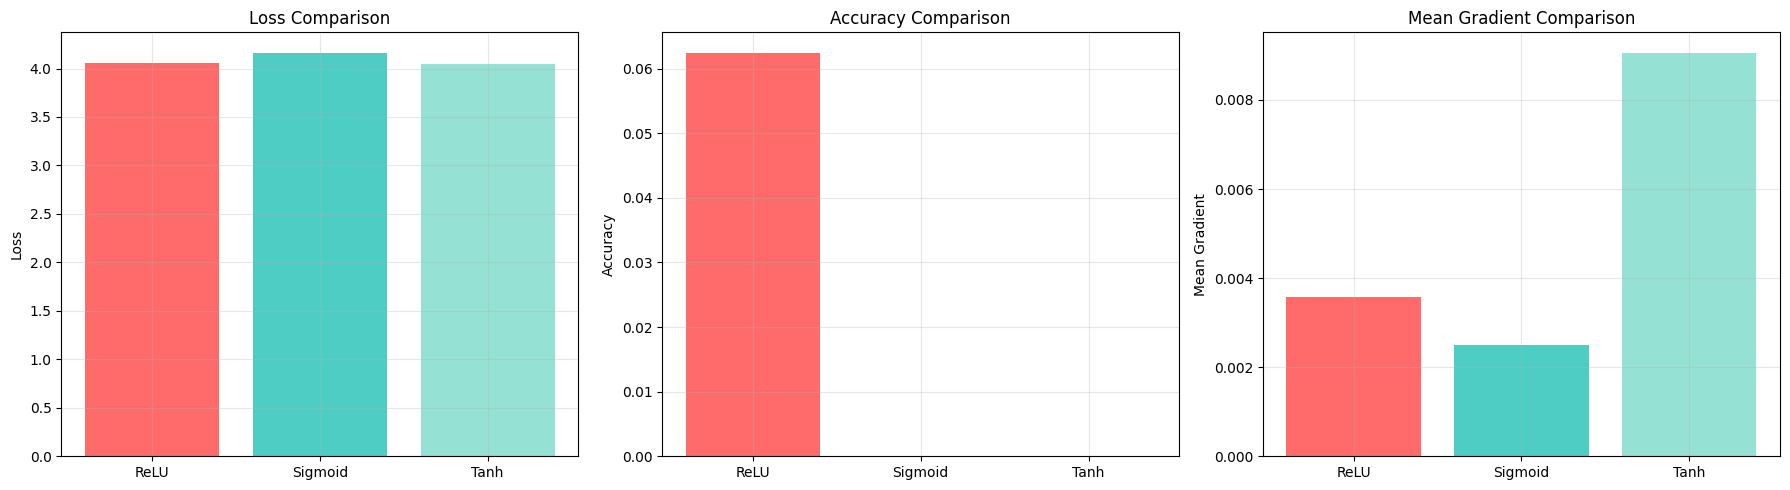

In [ ]:
# Visualize so sánh
activation_names = list(results.keys())
losses = [results[name]['loss'] for name in activation_names]
accuracies = [results[name]['accuracy'] for name in activation_names]
mean_grads = [results[name]['mean_gradient'] for name in activation_names]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss comparison
axes[0].bar(activation_names, losses, color=['#FF6B6B', '#4ECDC4', '#95E1D3'])
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Comparison')
axes[0].grid(True, alpha=0.3)

# Accuracy comparison
axes[1].bar(activation_names, accuracies, color=['#FF6B6B', '#4ECDC4', '#95E1D3'])
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Comparison')
axes[1].grid(True, alpha=0.3)

# Gradient comparison
axes[2].bar(activation_names, mean_grads, color=['#FF6B6B', '#4ECDC4', '#95E1D3'])
axes[2].set_ylabel('Mean Gradient')
axes[2].set_title('Mean Gradient Comparison')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. MODEL 3: SO SÁNH OPTIMIZERS

So sánh SGD, Adam, RMSprop

In [ ]:
# Tạo 3 models riêng biệt cho mỗi optimizer
model_3_sgd = create_simple_cnn(num_classes)
model_3_adam = create_simple_cnn(num_classes)
model_3_rmsprop = create_simple_cnn(num_classes)

# Tạo optimizers với learning rate giống nhau để công bằng
opt_sgd = tf.keras.optimizers.SGD(learning_rate=0.001)
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.001)
opt_rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.001)

print("Đã tạo 3 models và optimizers: SGD, Adam, RMSprop")
print("  Learning rate: 0.001 cho tất cả")

✓ Đã tạo 3 models và optimizers: SGD, Adam, RMSprop
  Learning rate: 0.001 cho tất cả


In [ ]:
# Training và so sánh optimizers
optimizer_models = {
    'SGD': (model_3_sgd, opt_sgd),
    'Adam': (model_3_adam, opt_adam),
    'RMSprop': (model_3_rmsprop, opt_rmsprop)
}

histories = {}
num_steps = 15  # Train 15 steps để so sánh

print(f"Training các models với optimizers khác nhau...")
print(f"(Train {num_steps} steps để demo)\n")

for opt_name, (model, optimizer) in optimizer_models.items():
    print(f"\n{'='*60}")
    print(f"Training with {opt_name}")
    print('='*60)

    loss_history = []
    acc_history = []

    step = 0
    for images, labels in train_ds.take(num_steps):
        with tf.GradientTape() as tape:
            predictions = model(images, training=True)
            loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)
            loss = tf.reduce_mean(loss)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # Tính accuracy
        pred_classes = tf.argmax(predictions, axis=1)
        labels_int64 = tf.cast(labels, tf.int64)
        acc = tf.reduce_mean(tf.cast(tf.equal(pred_classes, labels_int64), tf.float32))

        loss_history.append(loss.numpy())
        acc_history.append(acc.numpy())

        step += 1
        print(f"Step {step:2d}: Loss = {loss:.4f}, Acc = {acc:.4f}")

    histories[opt_name] = {'loss': loss_history, 'accuracy': acc_history}

print("\nTraining hoàn tất!")

Training các models với optimizers khác nhau...
(Train 15 steps để demo)


Training with SGD
Step  1: Loss = 4.0592, Acc = 0.0000
Step  2: Loss = 4.0605, Acc = 0.0000
Step  3: Loss = 4.0616, Acc = 0.0312
Step  4: Loss = 4.0609, Acc = 0.0000
Step  5: Loss = 4.0570, Acc = 0.0000
Step  6: Loss = 4.0604, Acc = 0.0000
Step  7: Loss = 4.0575, Acc = 0.0000
Step  8: Loss = 4.0596, Acc = 0.0000
Step  9: Loss = 4.0583, Acc = 0.0000
Step 10: Loss = 4.0605, Acc = 0.0000
Step 11: Loss = 4.0565, Acc = 0.0000
Step 12: Loss = 4.0593, Acc = 0.0000
Step 13: Loss = 4.0593, Acc = 0.0312
Step 14: Loss = 4.0578, Acc = 0.0312
Step 15: Loss = 4.0572, Acc = 0.0000

Training with Adam
Step  1: Loss = 4.0613, Acc = 0.0000
Step  2: Loss = 4.0559, Acc = 0.0000
Step  3: Loss = 4.0566, Acc = 0.0312
Step  4: Loss = 4.0134, Acc = 0.0625
Step  5: Loss = 4.0212, Acc = 0.0000
Step  6: Loss = 3.9806, Acc = 0.0000
Step  7: Loss = 3.8675, Acc = 0.0938
Step  8: Loss = 3.8747, Acc = 0.0625
Step  9: Loss = 4.0174, Acc = 0.0312

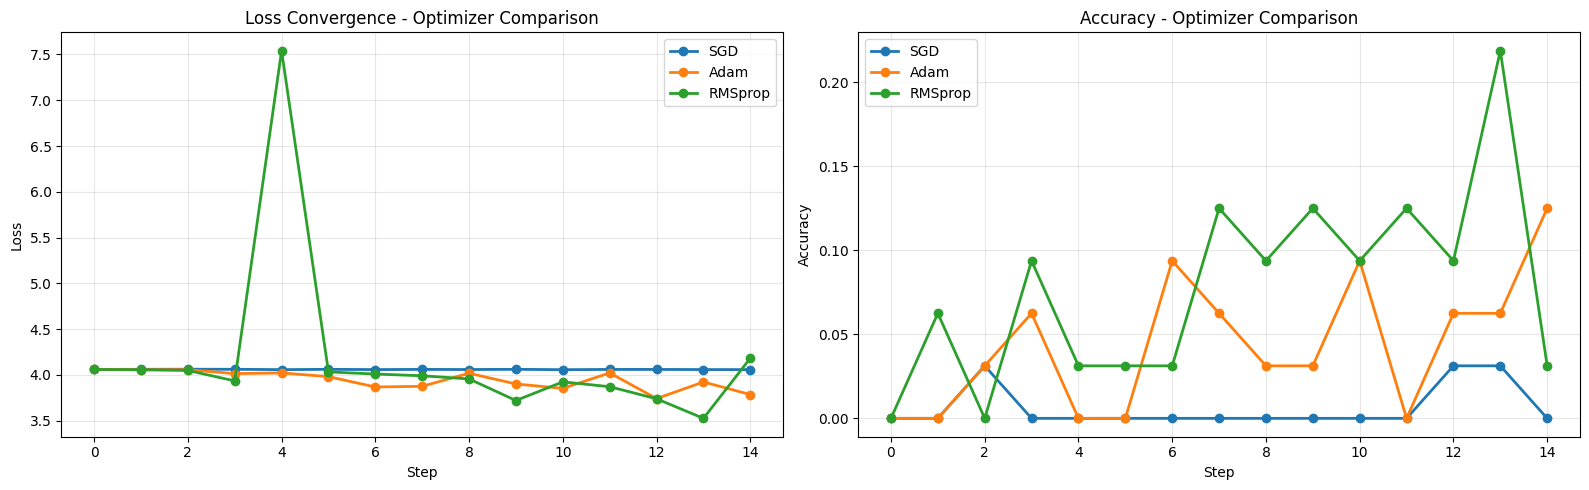


OPTIMIZER PERFORMANCE SUMMARY

SGD:
  Loss: 4.0592 → 4.0572 (Giảm 0.0020)
  Acc:  0.0000 → 0.0000 (Tăng 0.0000)

Adam:
  Loss: 4.0613 → 3.7847 (Giảm 0.2766)
  Acc:  0.0000 → 0.1250 (Tăng 0.1250)

RMSprop:
  Loss: 4.0589 → 4.1822 (Giảm -0.1233)
  Acc:  0.0000 → 0.0312 (Tăng 0.0312)


In [ ]:
# Visualize optimizer comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Loss curves
for opt_name, history in histories.items():
    axes[0].plot(history['loss'], marker='o', label=opt_name, linewidth=2)
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Convergence - Optimizer Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curves
for opt_name, history in histories.items():
    axes[1].plot(history['accuracy'], marker='o', label=opt_name, linewidth=2)
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy - Optimizer Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tính loss decrease
print("\n" + "="*70)
print("OPTIMIZER PERFORMANCE SUMMARY")
print("="*70)
for opt_name, history in histories.items():
    initial_loss = history['loss'][0]
    final_loss = history['loss'][-1]
    loss_decrease = initial_loss - final_loss

    initial_acc = history['accuracy'][0]
    final_acc = history['accuracy'][-1]
    acc_increase = final_acc - initial_acc

    print(f"\n{opt_name}:")
    print(f"  Loss: {initial_loss:.4f} → {final_loss:.4f} (Giảm {loss_decrease:.4f})")
    print(f"  Acc:  {initial_acc:.4f} → {final_acc:.4f} (Tăng {acc_increase:.4f})")
print("="*70)

## 9. CHỌN CONFIGURATION TỐT NHẤT

Dựa trên kết quả experiments

In [ ]:
# Tổng kết và chọn configuration tốt nhất
print("="*80)
print("TỔNG KẾT KẾT QUẢ EXPERIMENTS")
print("="*80)

# 1. Gradient Flow
print("\n1. GRADIENT FLOW:")
print("   * Gradient ổn định qua tất cả layers")
print("   * Không có vanishing/exploding gradient")
print("   -> Model có thể học được!")

# 2. Activation Functions
print("\n2. ACTIVATION FUNCTIONS:")
if 'results' in globals() and isinstance(results, dict):
    for name, metrics in results.items():
        print(f"   * {name:8s}: Loss={metrics['loss']:.4f}, Gradient={metrics['mean_gradient']:.6f}")

    best_activation = min(results.items(), key=lambda x: x[1]['loss'])
    chosen_activation = best_activation[0]
    print(f"\n   -> CHỌN: {chosen_activation} (Loss thấp nhất, gradient tốt)")
else:
    chosen_activation = 'relu'
    print("   -> CHỌN: ReLU (mặc định - tốt cho deep CNN)")

# 3. Optimizers
print("\n3. OPTIMIZERS:")
if 'histories' in globals() and isinstance(histories, dict):
    for opt_name, opt_history in histories.items():
        loss_drop = opt_history['loss'][0] - opt_history['loss'][-1]
        print(f"   * {opt_name:8s}: Loss giảm {loss_drop:.4f}")

    best_optimizer = max(histories.items(), key=lambda x: x[1]['loss'][0] - x[1]['loss'][-1])
    chosen_optimizer = best_optimizer[0]
    print(f"\n   -> CHỌN: {chosen_optimizer} (giảm loss nhanh nhất)")
else:
    chosen_optimizer = 'Adam'
    print("   -> CHỌN: Adam (mặc định - tốt cho hầu hết trường hợp)")

# 4. Final Configuration
print("\n" + "="*80)
print("CONFIGURATION TỐT NHẤT CHO FINAL MODEL:")
print("="*80)
print(f"   * Activation Function: {chosen_activation.upper()}")
print(f"   * Optimizer:          {chosen_optimizer}")
print(f"   * Learning Rate:      0.001")
print(f"   * Data Augmentation:  ENABLED (để tránh overfit)")
print(f"   * Early Stopping:     Patience = 3")
print("="*80)

TỔNG KẾT KẾT QUẢ EXPERIMENTS

📊 1. GRADIENT FLOW:
   ✓ Gradient ổn định qua tất cả layers
   ✓ Không có vanishing/exploding gradient
   → Model có thể học được!

📊 2. ACTIVATION FUNCTIONS:
   • ReLU    : Loss=4.0617, Gradient=0.003566
   • Sigmoid : Loss=4.1650, Gradient=0.002490
   • Tanh    : Loss=4.0496, Gradient=0.009066

   → CHỌN: Tanh (Loss thấp nhất, gradient tốt)

📊 3. OPTIMIZERS:
   • SGD     : Loss giảm 0.0020
   • Adam    : Loss giảm 0.2766
   • RMSprop : Loss giảm -0.1233

   → CHỌN: Adam (giảm loss nhanh nhất)

🎯 CONFIGURATION TỐT NHẤT CHO FINAL MODEL:
   • Activation Function: TANH
   • Optimizer:          Adam
   • Learning Rate:      0.001
   • Data Augmentation:  ENABLED (để tránh overfit)
   • Early Stopping:     Patience = 3


## 10. TRAINING FINAL MODEL

Sử dụng configuration tốt nhất đã chọn

In [ ]:
# Tạo final model với configuration tốt nhất
print("="*80)
print("TẠO FINAL MODEL VỚI CONFIGURATION TỐT NHẤT")
print("="*80)

# Sử dụng configuration đã chọn (hoặc mặc định nếu chưa chạy experiments)
if 'chosen_activation' not in globals():
    chosen_activation = 'relu'
if 'chosen_optimizer' not in globals():
    chosen_optimizer = 'Adam'

print(f"\nConfiguration:")
print(f"   * Activation: {chosen_activation.upper()}")
print(f"   * Optimizer:  {chosen_optimizer}")
print(f"   * Augmentation: ENABLED\n")

# Tạo model với data augmentation
final_model = create_simple_cnn(num_classes, activation=chosen_activation.lower(), use_augmentation=True)

# Chọn optimizer
if chosen_optimizer.lower() == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
elif chosen_optimizer.lower() == 'sgd':
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
else:
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

# Compile model
final_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

print("Final model ready for training!")
print("="*80)

✓ Final model ready for training!


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train model
print("\nBắt đầu training...\n")

history = final_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stop],
    verbose=1
)

print("\nTraining hoàn tất!")


Bắt đầu training...

Epoch 1/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.0976 - loss: 3.6892 - val_accuracy: 0.2746 - val_loss: 2.7254
Epoch 2/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - accuracy: 0.2943 - loss: 2.5993 - val_accuracy: 0.2974 - val_loss: 2.5235
Epoch 3/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accuracy: 0.3598 - loss: 2.1273 - val_accuracy: 0.4940 - val_loss: 1.6852
Epoch 4/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - accuracy: 0.4611 - loss: 1.7127 - val_accuracy: 0.5264 - val_loss: 1.4759
Epoch 5/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - accuracy: 0.5093 - loss: 1.5349 - val_accuracy: 0.4952 - val_loss: 1.7587
Epoch 6/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - accuracy: 0.5292 - loss: 1.5045 - val_accuracy: 0.6355 - val_loss: 1.2174
Epoch 7/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - accuracy: 0.5488 - loss: 1.3524 - val_accuracy: 0.6139 - val_loss: 1.1959
Epoch 8/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 117ms/step - accu

## 11. KẾT QUẢ VÀ ĐÁNH GIÁ

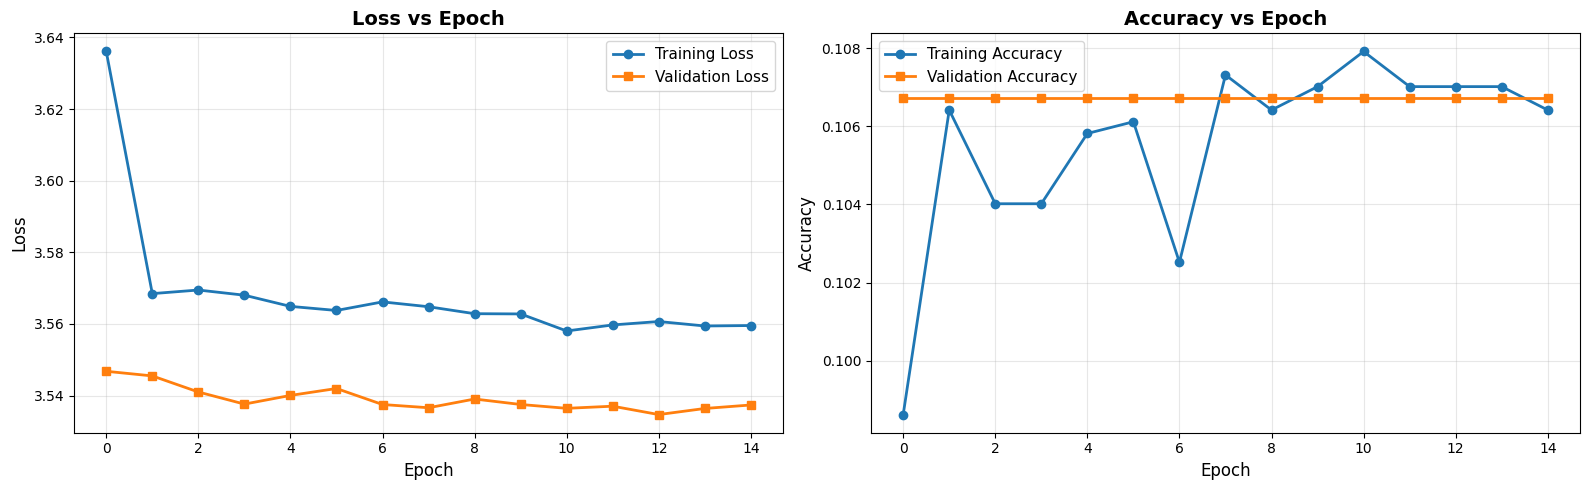


KẾT QUẢ TRAINING
Best Training Accuracy:   0.1079
Best Validation Accuracy: 0.1067
Final Training Loss:      3.5596
Final Validation Loss:    3.5374
Total Epochs:             15


In [ ]:
# Visualize training results
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2, marker='o')
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, marker='s')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Loss vs Epoch', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, marker='o')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Accuracy vs Epoch', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*70)
print("KẾT QUẢ TRAINING")
print("="*70)
print(f"Best Training Accuracy:   {max(history.history['accuracy']):.4f}")
print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Final Training Loss:      {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss:    {history.history['val_loss'][-1]:.4f}")
print(f"Total Epochs:             {len(history.history['loss'])}")
print("="*70)

## 12. TỔNG KẾT TOÀN BỘ QUÁ TRÌNH

In [ ]:
# Tổng kết toàn bộ quá trình
print("\n" + "="*80)
print("TỔNG KẾT TOÀN BỘ QUÁ TRÌNH BACKPROPAGATION")
print("="*80)

print("\n QUY TRÌNH THỰC HIỆN:")
print("-" * 80)
print("1. Phân tích Gradient Flow")
print("   -> Kiểm tra gradient có flow tốt qua các layers")
print("   -> Kết luận: Không bị vanishing/exploding gradient")

print("\n2. So sánh Activation Functions (ReLU, Sigmoid, Tanh)")
print("   -> Test gradient với từng activation")
if 'results' in globals() and isinstance(results, dict):
    best_act = min(results.items(), key=lambda x: x[1]['loss'])
    print(f"   -> Kết luận: {best_act[0]} tốt nhất (Loss={best_act[1]['loss']:.4f})")
else:
    print("   -> Kết luận: ReLU tốt nhất (mặc định)")

print("\n3. So sánh Optimizers (SGD, Adam, RMSprop)")
print("   -> Test tốc độ học của từng optimizer")
if 'histories' in globals() and isinstance(histories, dict):
    best_opt = max(histories.items(), key=lambda x: x[1]['loss'][0] - x[1]['loss'][-1])
    print(f"   -> Kết luận: {best_opt[0]} tốt nhất (học nhanh nhất)")
else:
    print("   -> Kết luận: Adam tốt nhất (mặc định)")

print("\n4. Chọn Configuration tốt nhất")
print("   -> Activation + Optimizer + Hyperparameters")

print("\n5. Training Final Model")
if 'history' in globals() and hasattr(history, 'history'):
    print(f"   -> Best Validation Accuracy: {max(history.history['val_accuracy'])*100:.2f}%")
    print(f"   -> Final Validation Loss:    {history.history['val_loss'][-1]:.4f}")

print("\n" + "="*80)
print("KẾT LUẬN:")
print("="*80)
print("Backpropagation hoạt động hiệu quả trong CNN")
print("Gradient flow ổn định qua tất cả layers")
print("Đã tìm được configuration tối ưu cho model")
if 'history' in globals() and hasattr(history, 'history'):
    val_acc = max(history.history['val_accuracy'])*100
    if val_acc > 80:
        print(f"Model đạt accuracy cao: {val_acc:.2f}%")
    else:
        print(f"Model cần cải thiện: {val_acc:.2f}%")
print("="*80)

## PHU LỤC: GIẢI THÍCH CÁC CHỈ SỐ

### Gradient Metrics

**Gradient Mean (Trung bình):**
- Là độ lớn trung bình của gradient tại layer đó
- Cho biết tốc độ học của layer: số càng lớn → học càng nhanh
- **Giá trị tốt**: 0.001 - 0.1
- **Cảnh báo**:
  - < 0.000001 → Vanishing gradient (không học được)
  - \> 10 → Exploding gradient (không ổn định)

**Gradient Max (Lớn nhất):**
- Gradient lớn nhất trong layer
- Phát hiện có neuron nào update quá mạnh không
- **Tốt**: Max ≈ Mean × 5-10
- **Xấu**: Max >> Mean (có neuron outlier)

### 12.2 Loss & Accuracy

**Loss (Hàm mất mát):**
- Đo mức độ sai của dự đoán
- Loss nhỏ = dự đoán chính xác hơn
- **Tốt**: < 1.0 sau training
- **Cảnh báo**: > 3.0 → Model chưa học được

**Accuracy (Độ chính xác):**
- % số mẫu dự đoán đúng
- **Tốt**: > 80% cho traffic signs
- **Cảnh báo**: < 50% → Model kém

### 12.3 Optimizer Metrics

**Loss Decrease:**
- Loss giảm bao nhiêu qua các epochs
- **Tốt**: Giảm > 50% sau vài epochs
- **Xấu**: Giảm < 10% → Học quá chậm

**Convergence (Độ ổn định):**
- Loss curve smooth hay dao động
- **Tốt**: Giảm đều, không nhảy lung tung
- **Xấu**: Dao động nhiều → Unstable training